In [82]:
# Cell 1: Install Required Libraries
!pip install tensorflow
!pip install imbalanced-learn
!pip install nltk
!pip install keras



In [84]:
# Cell 2: Import Necessary Libraries
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer  # Changed here
from tensorflow.keras.utils import pad_sequences, to_categorical  # Changed here
from tensorflow.keras.models import Model  # Changed here
from tensorflow.keras.layers import (Dense, Dropout, Input, Embedding,
                                      Flatten, Conv1D, GlobalMaxPooling1D,
                                      Bidirectional, LSTM, Attention)  # Changed here
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau  # Changed here
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from imblearn.over_sampling import SMOTE


In [52]:
# Cell 3: Download NLTK Resources
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
# Cell 4: Enable Multiple GPUs
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <= 1:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')


Using 0 GPU


In [55]:
# Cell 5: Load Dataset
data = pd.read_csv('/content/SC_4label.csv')
print(data.head())


   Unnamed: 0   filename                                               code  \
0           0  36375.sol  pragma solidity ^0.4.15;\n\n/*\n\n    CJX.io -...   
1           1  40298.sol  // <ORACLIZE_API>\n/*\nCopyright (c) 2015-2016...   
2           2  39858.sol  pragma solidity ^0.4.6;\n\n/*\n    Copyright 2...   
3           3  34598.sol  pragma solidity ^0.4.4;\n\ncontract Token {\n\...   
4           4  33490.sol  pragma solidity ^0.4.13;\n\ncontract DSAuthori...   

                                               label  label_encoded  
0  /content/drive/My Drive/SC_Dataset/reentrancy ...              2  
1  /content/drive/My Drive/SC_Dataset/reentrancy ...              2  
2  /content/drive/My Drive/SC_Dataset/reentrancy ...              2  
3  /content/drive/My Drive/SC_Dataset/reentrancy ...              2  
4  /content/drive/My Drive/SC_Dataset/reentrancy ...              2  


<ipython-input-56-d1fc8998e3c3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['label_encoded'], palette='Set1', alpha=0.8)


Text(0.5, 1.0, 'Distribution of vulnerabilities')

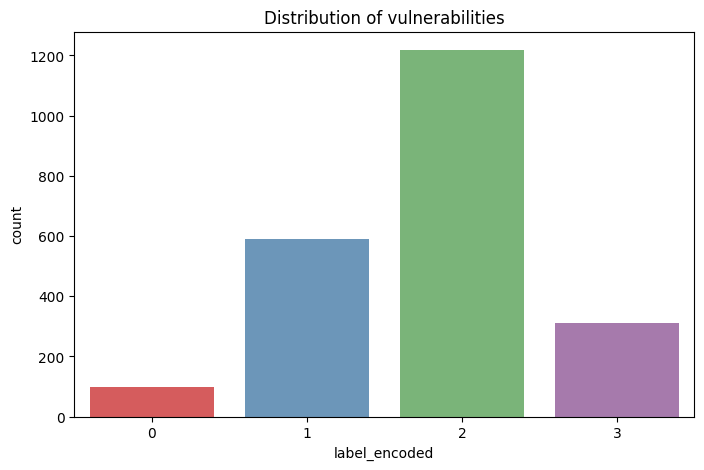

In [56]:
# Cell 6: Visualize Distribution of Vulnerabilities
plt.figure(figsize=(8, 5))
sns.countplot(x=data['label_encoded'], palette='Set1', alpha=0.8)
plt.title('Distribution of vulnerabilities')


In [77]:
# Cell 7: Prepare Data
X = data['code']
y = data['label_encoded']



Unique label types present in the dataset:
2
0
1
3


In [79]:
label_mapping = data[['label', 'label_encoded']].drop_duplicates().set_index('label_encoded').to_dict()['label']

print("Mapping of encoded values to original labels:")
for encoded_value, original_label in label_mapping.items():
    print(f"{encoded_value}: {original_label}")



Mapping of encoded values to original labels:
2: /content/drive/My Drive/SC_Dataset/reentrancy (RE)/
0: /content/drive/My Drive/SC_Dataset/dangerous delegatecall (DE)/
1: /content/drive/My Drive/SC_Dataset/integer overflow (OF)/
3: /content/drive/My Drive/SC_Dataset/timestamp dependency (TP)/


In [58]:
# Cell 8: Define Stop Words
solidity_stopwords = [
    "pragma", "interface", "contract", "function", "event", "modifier",
    "library", "using", "string", "uint8", "uint256", "address",
    "mapping", "bool", "require", "return", "memory", "storage",
    "public", "internal", "view", "returns", "constant", "constructor",
    "_owner", "_balances", "_allowances", "_founder", "_marketing",
    "_who", "_burntAmount", "_from", "_to", "_value", "_timestamp",
    "_bool", "msg.sender", "totalSupply", "balanceOf", "transfer",
    "allowance", "approve", "transferFrom", "add", "sub", "mul",
    "div", "mod", "changeFounder", "setMinter", "setFurnace",
    "freezeAccount", "solidity", "bytes32"
]

def clean_solidity_code(solidity_code):
    # Remove comments (both single-line and multi-line)
    cleaned_code = re.sub(r'//.*?$', '', solidity_code, flags=re.MULTILINE)
    cleaned_code = re.sub(r'/\*.*?\*/', '', cleaned_code, flags=re.DOTALL)

    # Remove special characters and punctuation
    cleaned_code = re.sub(r'[^a-zA-Z0-9\s]', '', cleaned_code)

    # Remove extra whitespace and blank lines, and convert to lowercase
    cleaned_code = '\n'.join(line.strip().lower() for line in cleaned_code.splitlines() if line.strip())

    # Remove common English stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in cleaned_code.split() if word not in stop_words]
    tokens = [token for token in tokens if token not in solidity_stopwords]
    cleaned_code = ' '.join(tokens)

    return tokens


In [59]:
# Cell 9: Clean the Code
X_cleaned = X.apply(clean_solidity_code)
X_cleaned_sentences = [' '.join(doc) for doc in X_cleaned]
X_cleaned_sentences = np.array(X_cleaned_sentences)


In [60]:
# Cell 10: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X_cleaned_sentences, y,
                                                    test_size=0.1, shuffle=True,
                                                    random_state=42, stratify=y)


In [61]:
# Cell 11: One-Hot Encoding Labels
y_train_encoded = to_categorical(y_train, 4)
y_test_encoded = to_categorical(y_test, 4)


In [62]:
# Cell 12: Tokenize the Text Data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)


In [63]:
# Cell 13: Padding the Sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=128, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=128, padding='post', truncating='post')

print('Shape of training tensor: ', X_train_padded.shape)
print('Shape of testing tensor: ', X_test_padded.shape)


Shape of training tensor:  (1995, 128)
Shape of testing tensor:  (222, 128)


In [64]:
# Cell 14: SMOTE Oversampling
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_padded, y_train_encoded)


In [65]:
# Cell 15: Model Definition
emb_len = len(tokenizer.index_word) + 1
input_layer = Input(shape=(128,))  # Specify max_len as the maximum sequence length
embedding_layer = Embedding(emb_len, 128)(input_layer)
lstm_layer = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.3))(embedding_layer)
attention = Attention()([lstm_layer, lstm_layer])  # Attention layer
conv1d_layer = Conv1D(64, kernel_size=3, activation='relu')(attention)
global_max_pooling_layer = GlobalMaxPooling1D()(conv1d_layer)
dense_layer_1 = Dense(128, activation='relu')(global_max_pooling_layer)
output_layer = Dense(4, activation='softmax')(dense_layer_1)


In [66]:
# Cell 16: Model Creation
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 128, 128)       │      5,820,160 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 128, 256)       │        263,168 │ embedding_1[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 128, 256)       │              0 │ bidirectional_1[0][0], │
│                           │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 126, 64)        │         49,216 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 64)             │              0 │ conv1d[0][0]           │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │          8,320 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 4)              │            516 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,141,380 (23.43 MB)

 Trainable params: 6,141,380 (23.43 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Cell 17: Save Model Path
checkpoint_path = '/content/best_model.keras'  # Changed extension to .keras
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


In [69]:
# Cell 18: Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=True)


In [70]:
# Cell 19: Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [75]:
# Cell 20: Training the Model
history = model.fit(X_train_resampled, y_train_resampled,
                    batch_size=32,
                    epochs=4,
                    validation_data=(X_test_padded, y_test_encoded),
                    callbacks=[model_checkpoint_callback, early_stop])


Epoch 1/4
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9731 - loss: 0.0678
Epoch 1: val_accuracy did not improve from 0.91441
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 649ms/step - accuracy: 0.9731 - loss: 0.0677 - val_accuracy: 0.8829 - val_loss: 0.4020
Epoch 2/4
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.9901 - loss: 0.0408
Epoch 2: val_accuracy did not improve from 0.91441
94/94 ━━━━━━━━━━━━━━━━━━━━ 80s 629ms/step - accuracy: 0.9901 - loss: 0.0408 - val_accuracy: 0.9054 - val_loss: 0.4083
Epoch 3/4
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.9913 - loss: 0.0298
Epoch 3: val_accuracy did not improve from 0.91441
94/94 ━━━━━━━━━━━━━━━━━━━━ 85s 665ms/step - accuracy: 0.9913 - loss: 0.0299 - val_accuracy: 0.8964 - val_loss: 0.4383
Epoch 3: early stopping


In [76]:

# Cell 21: Evaluate the Model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded, verbose=1)
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Loss: {loss:.4f}')


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.8974 - loss: 0.5020
Test Accuracy: 0.8964
Test Loss: 0.4383


In [86]:
max_words = 10000  # Adjusted as needed
max_sequence_length = 128  # Changed to match model input shape

# Initialize and fit the tokenizer on the training data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)  # Fit on the actual training dataset

def preprocess_input(text):
    """Preprocess the input text for prediction."""
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_sequence_length)
    return padded

# Sample input for prediction
sample_input = """

pragma solidity ^0.8.0;

contract VulnerableBank {
    mapping(address => uint256) public balances;

    // Deposit function to allow users to add funds
    function deposit() public payable {
        balances[msg.sender] += msg.value;
    }

    // Withdraw function that is vulnerable to reentrancy
    function withdraw(uint256 _amount) public {
        require(balances[msg.sender] >= _amount, "Insufficient balance");

        // Step 1: Transfer Ether to the user
        payable(msg.sender).transfer(_amount);

        // Step 2: Update the user's balance
        balances[msg.sender] -= _amount;
    }
}

"""

# Preprocess the sample input
sample_input_padded = preprocess_input(sample_input)

# Make predictions
sample_predictions = model.predict(sample_input_padded)
predicted_class = np.argmax(sample_predictions, axis=1)

# Mapping of encoded values to vulnerability types
vulnerability_types = {
    0: "Dangerous Delegatecall (DE)",
    1: "Integer Overflow (OF)",
    2: "Reentrancy (RE)",
    3: "Timestamp Dependency (TP)"
}

# Get the predicted vulnerability type
predicted_vulnerability = vulnerability_types.get(predicted_class[0], "Unknown")

print(f"Sample Input: {sample_input.strip()}")
print(f"Predicted Vulnerability Type: {predicted_vulnerability}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Sample Input: pragma solidity ^0.8.0;

contract VulnerableBank {
    mapping(address => uint256) public balances;

    // Deposit function to allow users to add funds
    function deposit() public payable {
        balances[msg.sender] += msg.value;
    }

    // Withdraw function that is vulnerable to reentrancy
    function withdraw(uint256 _amount) public {
        require(balances[msg.sender] >= _amount, "Insufficient balance");

        // Step 1: Transfer Ether to the user
        payable(msg.sender).transfer(_amount);

        // Step 2: Update the user's balance
        balances[msg.sender] -= _amount;
    }
}
Predicted Vulnerability Type: Dangerous Delegatecall (DE)


In [87]:
import pickle
from tensorflow.keras.models import load_model

# Save the trained model
model.save('vulnerability_detection_model.h5')

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [88]:
from google.colab import files

files.download('vulnerability_detection_model.h5')
files.download('tokenizer.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>